In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile

### Setup:
  - Run `latency_test.yaml` with buffer size set to 192 and nperiods set to 3



In [234]:
expdir = '../ExperimentLog2020-06-16_1457' # 192 x 2

#expdir = '../ExperimentLog2020-06-16_1502' # 64 x 2
import os
fs, data = scipy.io.wavfile.read(os.path.join(expdir, 'microphone.wav'))

In [235]:
audio_ts = np.loadtxt(os.path.join(expdir,'microphone.wav.log'), delimiter=',', skiprows=2)

In [236]:
buffer_sizes = np.unique(audio_ts[:,0])
print(buffer_sizes)

[1024.]


In our example, we only see one value.

**B = 1024** should correspond to a delay of about 1024/48000 (the sampling rate for this file). So next, let's check for excessive differences in the timestamps.

In [237]:
diff_ts = np.diff(audio_ts[:,1]/1e9) # convert timestamps to seconds (from ns) and take a diff
np.where(diff_ts > (buffer_sizes[0]/fs)*1.2)

(array([], dtype=int64),)

In our example, we didn't find any values more than 1.2 times the expected buffer size. Let's look at a histogram just to be fun.

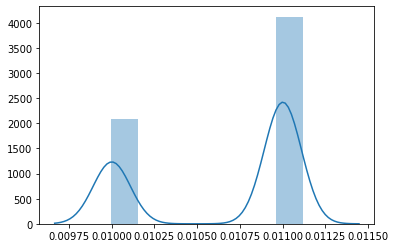

In [238]:
import seaborn as sns
sns.distplot(diff_ts)

I'm not sure what the two peaks mean. 

In order to get timestamps for each sample, let's regress our data!

Measured slope: {}. Expected (1/FS): {} 1.0414313759373376e-05 1.0416666666666666e-05
Time for (N-B) samples:  16.338216129996
Print N-B is:  1568768.0
Approximate FS is:  96018.31604613399


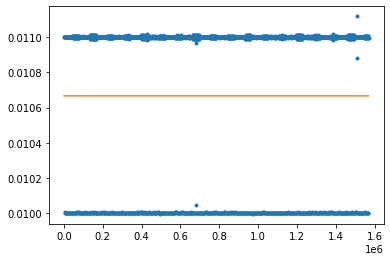

In [239]:
import scipy.stats

n_buffer = np.cumsum(audio_ts[:,0])
buffer_ts = audio_ts[:,1]/1e9

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(n_buffer,buffer_ts)

print('Measured slope: {}. Expected (1/FS): {}', slope, 1/fs)

plt.plot(n_buffer[:-1],np.diff(audio_ts[:,1])/1e9,'.')
plt.plot(n_buffer[:-1],np.ones(n_buffer.shape[0]-1)*buffer_sizes[0]/fs)

print('Time for (N-B) samples: ', (buffer_ts[-1]-buffer_ts[0]))
print('Print N-B is: ', n_buffer[-1]-n_buffer[0])
print('Approximate FS is: ', (n_buffer[-1]-n_buffer[0])/(buffer_ts[-1]-buffer_ts[0]))

### Look at some data
Next, let's look at our data. In this example file, the tones are on channel 1 and the pulses are on channel 0.

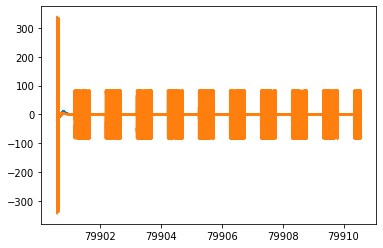

In [240]:
t_sound = intercept + np.arange(0, data.shape[0], step=1) * slope
plt.plot(t_sound[:96000*10], data[:96000*10,:]);


In [241]:
import nelpy as nel

### GPIO Data

Next, let's load the GPIO data. It's also stored in a CSV file. Each row corresponds to a record with
  1. The master time (from the clock on the IO board) - these should increment exactly 2 ms each sample
  2. GPIO - an Int corresonding to the values of each of the pins
  3. Encoder - the value of the rotational encoder. For our situation, the encoder usually goes from 0 to 4095
  4. UnwrappedEncoder - the unwrapped value of the encoder - this increments all the way to the maximum value (32 bit)
  5. last_ts - the CLOCK_MONOTONIC value (converted to seconds) received at the sampling time

In [242]:
gpio_data = np.loadtxt(os.path.join(expdir, 'DataLog.csv'), delimiter=',', skiprows=2)

Next, let's look at the pulses as recorded by the GPIO

In [243]:
gpio_pulse_train_data = gpio_data[:,1].astype(int) & 1 # Our pulse pin is channel 0 (0x0001)
gpio_response_train_data = gpio_data[:,1].astype(int) & 4 # Our pulse pin is channel 0 (0x0001)

Again, we'll use `nelpy.utils.get_threshold_crossing_epochs` to find them. We'll use the `CLOCK_MONOTONIC` timestamps rather than the 1 kHz Master Clock so that we can match them up to the audio.

In [244]:
gpio_pulses_nel = nel.AnalogSignalArray(gpio_pulse_train_data.astype(float), time=gpio_data[:,-1],fs=500)
boundaries, _, _ = nel.utils.get_events_boundaries(gpio_pulses_nel.data, PrimaryThreshold=0.9, SecondaryThreshold=0.1)
gpio_pulse_epochs = nel.EpochArray(gpio_pulses_nel.time[boundaries]-0.0005) # get off perfect boundaries

gpio_responses_nel = nel.AnalogSignalArray(gpio_response_train_data.astype(float), time=gpio_data[:,-1])

In [245]:
audio_tone_nel = nel.AnalogSignalArray(data[:,1], time=t_sound, fs=96000)

Text(0.5, 0, 'Time (s)')

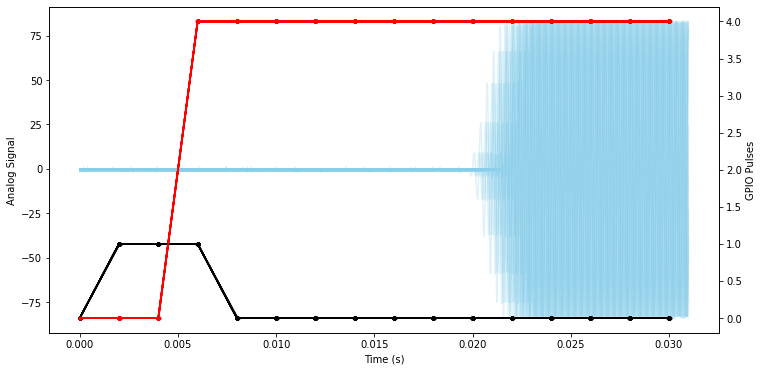

In [246]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax2 = ax.twinx()
for ep in gpio_pulse_epochs[1:]:
    t = audio_tone_nel[ep.expand(0.002, direction='start').expand(0.025, direction='stop')].abscissa_vals
    d1 = audio_tone_nel[ep.expand(0.002, direction='start').expand(0.025, direction='stop')].data
    g1 = gpio_pulses_nel[ep.expand(0.002, direction='start').expand(0.025, direction='stop')].data
    tg1 = gpio_pulses_nel[ep.expand(0.002, direction='start').expand(0.025, direction='stop')].abscissa_vals
    r1 = gpio_responses_nel[ep.expand(0.002, direction='start').expand(0.025, direction='stop')].data

    ax.plot(t - t[0], d1.T, color='skyblue', alpha=0.25)
    ax2.plot(tg1 - tg1[0], g1.T, 'k.-')
    ax2.plot(tg1 - tg1[0], r1.T, 'r.-')
    
ax2.set_ylabel('GPIO Pulses')
ax.set_ylabel('Analog Signal')
ax.set_xlabel('Time (s)')

We see from the above figure that the latency may actually come from something about the way that the threshold crossing algorithm is being implemented for the GPIOs. The actual time of the GPIO pulse being high is quite well aligned (sub-millisecond) with the pulse from the analog input.

The `latency_test.yaml` state machine is structured as follows: `RaiseGPIO` sets the pulse GPIO high with a conditional transition on the sense pin is detected high; `SignalGPIO` raises a second GPIO; `LowerPulse` lowers the pulse GPIO pin; `PlaySound` plays the sine wave. We can see that the time between when the GPIO is raised and lowered is 8 ms, which matches expectations (GPIO goes high, the next 2 ms tick it's detected (and a state transition is triggered), the next tick the `Signal` GPIO is raised, and the next tick it's lowered).

Also, we see that the time from the initial trigger pulse to the sine wave onset is about 13 ms. The sound transition is triggered after the GPIO is lowered, or 8 ms after the pulse went high. 6 ms of that 8 ms is just due to state machine transitions, so the "real" **closed-loop latency** - *the time between when an IO state change is detected and a change in sound is measurable on the sound card output* -  is about **7 ms**.


INFO:ghost:'timestamps' not passed in; generating from data


(500.0, 8000.0)

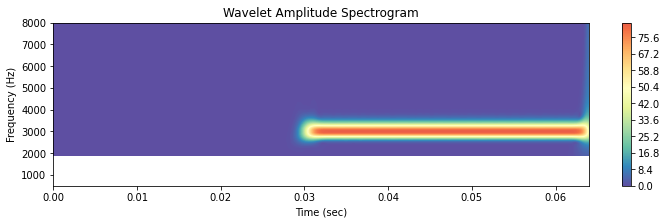

In [247]:
ep = gpio_pulse_epochs[1]
data = audio_tone_nel[ep.expand(0.01, direction='start').expand(0.05, direction='stop')].data.squeeze()
fs = 96000

fig, ax = plt.subplots(1,1,figsize=(12,3))
from ghost.wave import ContinuousWaveletTransform, Morse
wavelet = Morse(fs=fs, gamma=3, beta=60)
cwt = ContinuousWaveletTransform(wavelet=wavelet, )
cwt.transform(data, fs=fs, freq_limits=[256,8192], voices_per_octave=48)
c = cwt.plot(logscale=False,
         standardize=False,
         cmap=plt.cm.Spectral_r,
         vmax=100,
         levels=300, ax=ax) 
plt.colorbar(c, ax=ax)
ax.set_ylim(500,8000)
